In [1]:
import pandas as pd
import altair as alt
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Daily Nett Cases (2021 only)

This is the nett number of daily cases, which is computed by taking the difference between the daily new and recovered cases (new - recovered). The second chart is a 7-day moving average, which helps to smoothen the line, and account for the lower number of testing usually carried out on weekends.

Only 2021 numbers are shown as the focus is to visualize the current situation.

In both line charts, the zero line is highlighted in red.

In [2]:
#Reading CSV file for overall case numbers
cases_overall = pd.read_csv(
    'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv'
)

#Taking only necessary columns
cases_overall = cases_overall[['date', 'cases_new', 'cases_recovered']].copy()

#Renaming the columns
cases_overall = cases_overall.rename(columns = {
    'date':'Date', 'cases_new':'New', 'cases_recovered':'Recovered'
})

#Filtering for only 2021 numbers
cases_overall = cases_overall[cases_overall['Date'].str.contains("2021")]

#Adding new column for nett number of daily cases (new - recovered)
cases_overall['Nett'] = cases_overall.apply(lambda row: row['New'] - (row['Recovered']), axis = 1)

cases_overall.tail()

,Date,New,Recovered,Nett
583,2021-08-30,19268,21257,-1989
584,2021-08-31,20897,18465,2432
585,2021-09-01,18762,21073,-2311
586,2021-09-02,20988,23473,-2485
587,2021-09-03,19378,22399,-3021


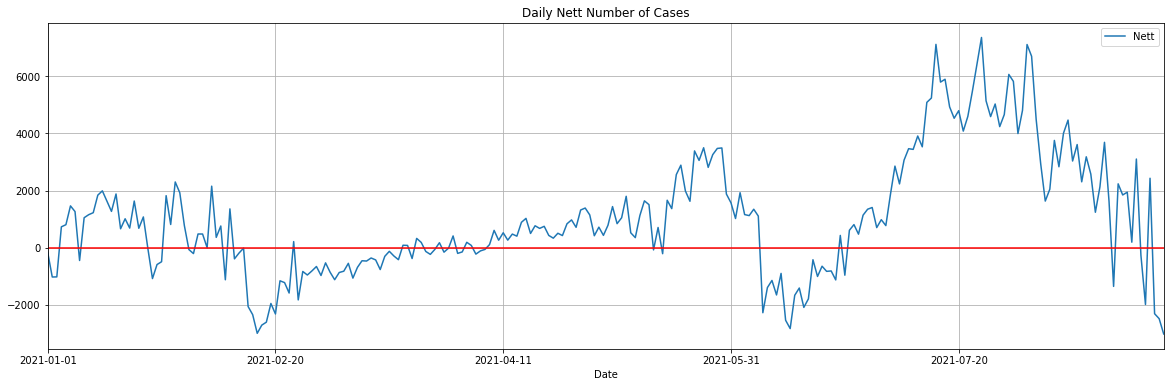

In [3]:
#Plotting line chart for daily nett cases (new - recovered)
cases_overall.plot(
    figsize=(20,6), 
    x='Date', 
    y=['Nett'],
    title='Daily Nett Number of Cases',
    grid=True
).axhline(y=0, color='red')

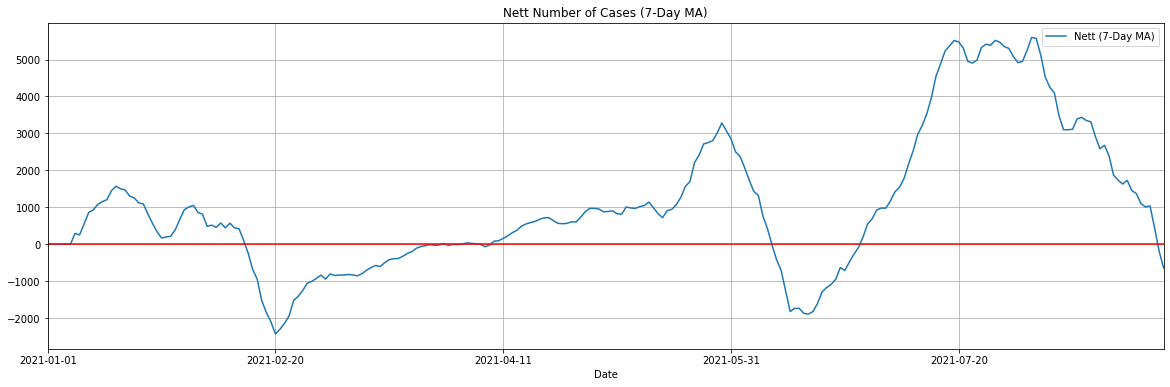

In [4]:
#Calculating 7-day moving average for nett cases
cases_overall['Nett (7-Day MA)'] = cases_overall[[
    'Nett']].rolling(window=7).mean().fillna(0).round(1)

#Plotting line chart for nett cases using the 7-day moving average value
cases_overall.plot(
    figsize=(20,6), 
    x='Date', 
    y=['Nett (7-Day MA)'],
    title='Nett Number of Cases (7-Day MA)',
    grid=True
).axhline(y=0, color='red')

# Active cases by state per capita

Shows current situation in each state. The red line in the chart is the mean value.

Perlis was dropped as it was seen to have more recovered then new cases.

In [5]:
#Reading CSV file for cases by state
cases_by_state = pd.read_csv(
    'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_state.csv'
)

#Summing up new and recovered cases for each state
cases_by_state = cases_by_state.groupby(['state'], as_index=False).agg({'cases_new':sum, 'cases_recovered':sum})

#Counting the number of active cases in each state (new - recovered)
cases_by_state['Active Cases'] = cases_by_state.apply(
    lambda row: row['cases_new'] - (row['cases_recovered']), axis = 1
)

#Dropping any unnecessary columns
cases_by_state = cases_by_state.drop(['cases_new', 'cases_recovered'], axis=1)

#Dropping Perlis (row 7) since it has more recovered than new cases
cases_by_state = cases_by_state.drop([7], axis=0)

#Renaming the columns
cases_by_state = cases_by_state.rename(columns = {'state':'State'})

In [6]:
#Reading CSV file for population numbers
population = pd.read_csv(
    'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/static/population.csv'
)

#Dropping any unnecessary columns
population = population.drop(['idxs', 'pop_18', 'pop_60'], axis=1)

#Renaming the columns
population = population.rename(columns = {'state':'State', 'pop':'Population'})

In [7]:
#Merging cases by state data with population data
active_cases_per_capita = cases_by_state.merge(population, how='inner')

#Calculating active cases per capita (Active cases / population)
active_cases_per_capita['Active Cases per Capita'] = active_cases_per_capita.apply(
    lambda row: row['Active Cases'] / (row['Population']), axis = 1
)

#Sorting by active cases per capita
active_cases_per_capita = active_cases_per_capita.sort_values(by='Active Cases per Capita', ascending=False)

#Resetting the index
active_cases_per_capita = active_cases_per_capita.reset_index(drop=True)

active_cases_per_capita

,State,Active Cases,Population,Active Cases per Capita
0,Pulau Pinang,40522.0,1773600,0.022847
1,Perak,51844.0,2510300,0.020653
2,W.P. Kuala Lumpur,33610.0,1773700,0.018949
3,Selangor,112324.0,6538000,0.017180
4,Kedah,32993.0,2185100,0.015099
5,Sarawak,37746.0,2816500,0.013402
6,Sabah,49714.0,3908500,0.012719
7,Melaka,11649.0,932700,0.012490
8,Kelantan,22965.0,1906700,0.012044
9,W.P. Putrajaya,1158.0,110000,0.010527


In [8]:
#Plotting bar chart for cases by state per capita
bar = alt.Chart(active_cases_per_capita).mark_bar(
    
    #To give the bars a rounded edge
    cornerRadiusTopLeft=10,
    cornerRadiusTopRight=10
).encode(
    
    #Sorting the values according to active cases per capita
    x=alt.X('State', sort='-y'),
    y='Active Cases per Capita',
    color=alt.condition(
        alt.datum.year == 0,
        alt.value('red'),
        alt.value('#4b7d8d')
    )
)

#Adds a red line marking the mean value
rule = alt.Chart(active_cases_per_capita).mark_rule(color='red').encode(
    y='mean(Active Cases per Capita)'
)

(bar + rule).properties(width=850, height=500, title='Active Cases per Capita by State')

alt.LayerChart(...)

# Nett Cases per Capita (Last 7 Days)

This shows the nett number of cases for each state (per capita) recorded in the last 7 days.  The red line in the chart is the mean value.

In [9]:
#Reading CSV file for state case numbers
new_cases_by_state = pd.read_csv(
    'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_state.csv'
)

#Converting date column to datetime datatype
new_cases_by_state['date'] = pd.to_datetime(new_cases_by_state['date'])

#Extracting only numbers for the latest week
new_cases_by_state = new_cases_by_state.loc[(
    new_cases_by_state['date'] > (new_cases_by_state['date'].iloc[-1] - timedelta(days=7))
)]

#Dropping any unnecessary columns
new_cases_by_state = new_cases_by_state.drop(['cases_import', 'date'], axis=1)

#Renaming the columns
new_cases_by_state = new_cases_by_state.rename(columns = {
    'state':'State', 'cases_new':'New', 'cases_recovered':'Recovered'
})

#Grouping the numbers by state
new_cases_by_state = new_cases_by_state.groupby(['State'], as_index=False).agg({'New':sum, 'Recovered':sum})

#Merging data with population data
new_cases_by_state = new_cases_by_state.merge(population, how='inner')

#Calculating nett cases per capita ( (new-recovered) / population)
new_cases_by_state['Nett Cases per Capita'] = new_cases_by_state.apply(
    lambda row: (row['New'] - row['Recovered']) / (row['Population']), axis = 1
)

#Sorting the values by nett cases per capita
new_cases_by_state = new_cases_by_state.sort_values(by='Nett Cases per Capita', ascending=False)

#Resetting the index
new_cases_by_state = new_cases_by_state.reset_index(drop=True)

new_cases_by_state

,State,New,Recovered,Population,Nett Cases per Capita
0,Pulau Pinang,11898,1128.0,1773600,0.006072
1,Sarawak,17132,855.0,2816500,0.005779
2,Kedah,13453,1867.0,2185100,0.005302
3,Kelantan,9499,1356.0,1906700,0.004271
4,Sabah,17479,1136.0,3908500,0.004181
5,Selangor,29740,6376.0,6538000,0.003574
6,Johor,14641,1272.0,3781000,0.003536
7,Terengganu,4705,581.0,1259300,0.003275
8,Perak,7895,905.0,2510300,0.002785
9,Melaka,2832,432.0,932700,0.002573


In [16]:
#Plotting bar chart for nett cases per capita (last 7 days)
bar = alt.Chart(new_cases_by_state).mark_bar(
   
    #To give the bars a rounded edge
    cornerRadiusTopLeft=10,
    cornerRadiusTopRight=10
).encode(
    
    #Sorting the values
    x=alt.X('State', sort='-y'),
    y='Nett Cases per Capita',
    color=alt.condition(
        alt.datum.year == 0,
        alt.value('red'),
        alt.value('#4b7d8d')
    )
)

#Adds a red line marking the mean value
rule = alt.Chart(new_cases_by_state).mark_rule(color='red').encode(
    y='mean(Nett Cases per Capita)'
)

(bar + rule).properties(width=850, height=500, title='Nett Cases per Capita (Last 7 Days)')

alt.LayerChart(...)

# ICU usage (%) by state

This talks about only COVID-19 patients under ICU; non-covid patients are excluded.
It shows the current situation, and it is a lagging indicator for each state's progess.

In the bar chart, states with usages of 100% and above are highlighted.

In [11]:
#Reading CSV file for icu usage
icu_usage_by_state = pd.read_csv(
    'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/icu.csv'
)

#Filtering for only latest numbers
icu_usage_by_state = icu_usage_by_state.loc[(icu_usage_by_state['date'] == icu_usage_by_state['date'].iloc[-1])]

#Calculating total number of patients in ICU (icu_covid + icu_pui)
icu_usage_by_state['Patients'] = icu_usage_by_state.apply(
    lambda row: row['icu_covid'] + (row['icu_pui']), axis = 1
)

#Calculating ICU usage (%) and rounding to 1 decimal place
icu_usage_by_state['Usage (%)'] = icu_usage_by_state.apply(
    lambda row: row['Patients'] / (row['beds_icu_covid']) * 100, axis = 1
).round(1)

#Taking only relevant columns
icu_usage_by_state = icu_usage_by_state[['state', 'beds_icu_covid', 'Patients', 'Usage (%)']].copy()

#Renaming the columns
icu_usage_by_state = icu_usage_by_state.rename(columns = {'state':'State', 'beds_icu_covid':'Beds'})

#Sorting the values
icu_usage_by_state = icu_usage_by_state.sort_values(by='Usage (%)', ascending=False)

#Resetting the index
icu_usage_by_state = icu_usage_by_state.reset_index(drop=True)

icu_usage_by_state

,State,Beds,Patients,Usage (%)
0,Kedah,105,123,117.1
1,Sabah,143,156,109.1
2,Perak,90,98,108.9
3,Perlis,11,11,100.0
4,Selangor,335,324,96.7
5,Kelantan,77,74,96.1
6,Melaka,90,86,95.6
7,Johor,108,101,93.5
8,Pulau Pinang,77,72,93.5
9,Pahang,66,52,78.8


In [12]:
#Plotting bar chart for ICU usage by state

bar = alt.Chart(icu_usage_by_state).mark_bar(
    #To give the bars a rounded edge
    cornerRadiusTopLeft=10,
    cornerRadiusTopRight=10
).encode(
    #Sorting the values
    x=alt.X('State', sort='-y'),
    y='Usage (%)',
    color=alt.condition(
        alt.datum['Usage (%)'] >= 100,
        alt.value('#d73d6c'),
        alt.value('#4b7d8d')
    )
).properties(width=850, height=500, title='ICU Usage (%) by State')

bar

alt.Chart(...)

# Weekly deaths by state per capita

This shows the number of deaths by state per capita for the last 7 days.

In [13]:
#Reading CSV file for deaths
deaths_by_state = pd.read_csv(
    'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/deaths_state.csv'
)

#Converting date column to datetime datatype
deaths_by_state['date'] = pd.to_datetime(deaths_by_state['date'])

#Extracting only numbers for the latest week
deaths_by_state = deaths_by_state.loc[(
    deaths_by_state['date'] > (deaths_by_state['date'].iloc[-1] - timedelta(days=7))
)]

#Dropping any unnecessary columns
deaths_by_state = deaths_by_state.drop(['deaths_bid'], axis=1)

#Renaming columns
deaths_by_state = deaths_by_state.rename(columns = {'date':'Date', 'state':'State', 'deaths_new':'Deaths'})

#Grouping the numbers by state
deaths_by_state = deaths_by_state.groupby(['State'], as_index=False).agg({'Deaths':sum})

#Merging data with population data
deaths_by_state = deaths_by_state.merge(population, how='inner')

#Calculating deaths per capita (new cases / population)
deaths_by_state['Deaths per Capita'] = deaths_by_state.apply(
    lambda row: row['Deaths'] / (row.Population), axis = 1
)

#Sorting the values by deaths per capita
deaths_by_state = deaths_by_state.sort_values(by='Deaths per Capita', ascending=False)

#Resetting the index
deaths_by_state = deaths_by_state.reset_index(drop=True)

deaths_by_state

,State,Deaths,Population,Deaths per Capita
0,Selangor,740,6538000,0.000113
1,Pulau Pinang,158,1773600,0.000089
2,Johor,309,3781000,0.000082
3,Melaka,58,932700,0.000062
4,W.P. Kuala Lumpur,109,1773700,0.000061
5,Kedah,129,2185100,0.000059
6,Sabah,226,3908500,0.000058
7,Perlis,8,254900,0.000031
8,Perak,72,2510300,0.000029
9,Kelantan,46,1906700,0.000024


In [14]:
#Plotting bar chart for deaths per capita by state

bar = alt.Chart(deaths_by_state).mark_bar(
    
    #To give the bars a rounded edge
    cornerRadiusTopLeft=10,
    cornerRadiusTopRight=10
).encode(
    
    #Sorting the values
    x=alt.X('State', sort='-y'),
    y='Deaths per Capita',
    color=alt.condition(
        alt.datum.year == 0,
        alt.value('red'),
        alt.value('#4b7d8d')
    )
)

#Adds a red line marking the mean value
rule = alt.Chart(deaths_by_state).mark_rule(color='red').encode(
    y='mean(Deaths per Capita)'
)

(bar + rule).properties(width=850, height=500, title='Deaths per Capita by State')


alt.LayerChart(...)

# 7-Day Moving Average (2021 only)

This chart shows the 7-day moving average for new cases, recovered cases, and deaths. 

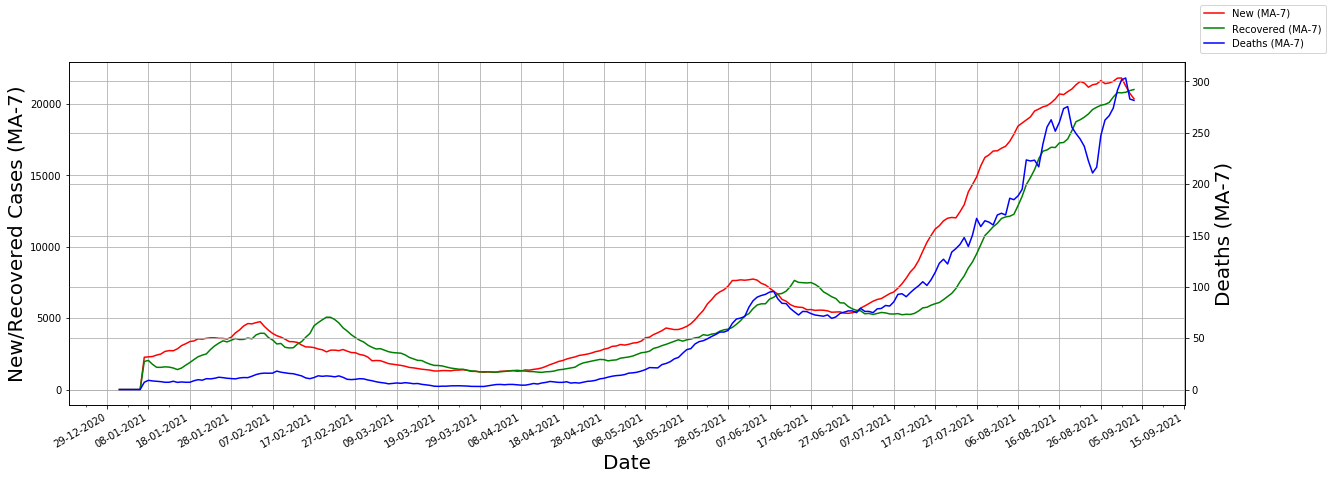

In [15]:
#Reading CSV file for overall deaths
deaths_overall = pd.read_csv(
    'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/deaths_malaysia.csv'
)

#Filtering for only 2021 numbers
deaths_overall = deaths_overall[deaths_overall['date'].str.contains("2021")]

#Calculating 7-Day Moving Average, filling NA values with 0, and rounding to 1 decimal place
cases_overall['New (MA-7)'] = cases_overall[[
    'New']].rolling(window=7).mean().fillna(0).round(1)
cases_overall['Recovered (MA-7)'] = cases_overall[[
    'Recovered']].rolling(window=7).mean().fillna(0).round(1)
deaths_overall['Deaths (MA-7)'] = deaths_overall[[
    'deaths_new']].rolling(window=7).mean().fillna(0).round(1)

#Renaming the column
deaths_overall = deaths_overall.rename(columns = {'date':'Date'})

#Merging with the overall cases table
seven_day = deaths_overall.merge(cases_overall, how='inner')

#Converting datatype of date column
seven_day['Date'] = pd.to_datetime(seven_day['Date'])

#Plotting the chart for all 3 moving averages
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(seven_day['Date'], seven_day['New (MA-7)'], color="red")
ax.plot(seven_day['Date'], seven_day['Recovered (MA-7)'], color="green")
ax.set_ylabel('New/Recovered Cases (MA-7)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)

ax2=ax.twinx()
ax2.plot(seven_day['Date'], seven_day['Deaths (MA-7)'],color="blue")
ax2.set_ylabel('Deaths (MA-7)', fontsize=20)

#Displaying the legend
fig.legend(labels=['New (MA-7)', 'Recovered (MA-7)', 'Deaths (MA-7)'], loc="upper right")

#Only show a date on the x-axis once every 10 days
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))

#Formatting the date shown on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.grid()
ax2.grid()

plt.show()